Demo 6 –Rigid Transform in 3D
200345N

Final Transform Parameters:
[-5.19015935e-04 -5.89191430e-04 -8.71149468e-02  2.52881460e+00
 -1.63563623e+01  7.11142410e-02]
Translation (x, y, z):
[  2.5288146  -16.35636227   0.07111424]
Rotation Versor :
[-0.00051902 -0.00058919 -0.08711495]


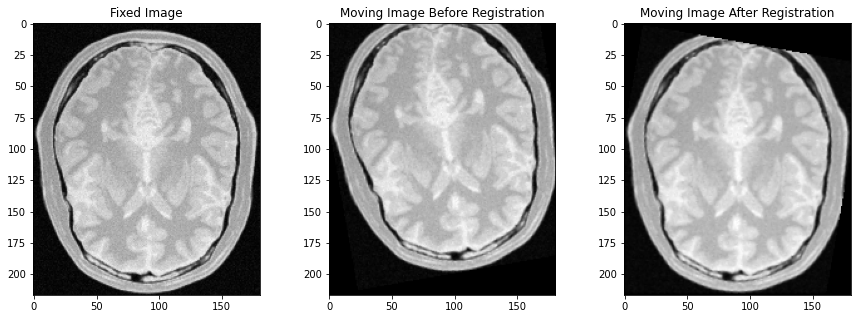

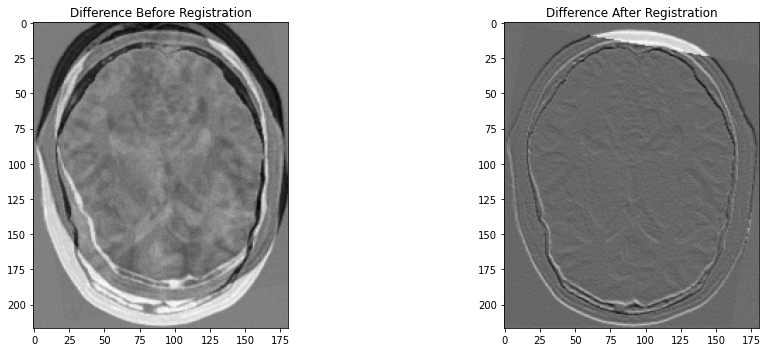

<itk.itkImageRegistrationMethodv4Python.itkImageRegistrationMethodv4REGv4F3F3; proxy of <Swig Object of type 'itkImageRegistrationMethodv4REGv4F3F3 *' at 0x00000241DB1ABCC0> >

In [1]:
import itk
import numpy as np
import matplotlib.pyplot as plt

def perform_rigid_3D_registration(fixed_image_path, moving_image_path):
    PixelType = itk.ctype("float")
    Dimension = 3

    # Read images
    fixed_image = itk.imread(fixed_image_path, PixelType)
    moving_image = itk.imread(moving_image_path, PixelType)

    # Define the image types for 3D
    FixedImageType = itk.Image[PixelType, Dimension]
    MovingImageType = itk.Image[PixelType, Dimension]

    # Define the transform type for 3D rigid registration
    TransformType = itk.VersorRigid3DTransform[itk.D]
    initial_transform = TransformType.New()

    # CenteredTransformInitializer
    TransformInitializerType = itk.CenteredTransformInitializer[
        TransformType, FixedImageType, MovingImageType]
    initializer = TransformInitializerType.New()

    initializer.SetTransform(initial_transform)
    initializer.SetFixedImage(fixed_image)
    initializer.SetMovingImage(moving_image)
    initializer.MomentsOn()  # Initialize using center of mass
    initializer.InitializeTransform()

    # Optimizer setup
    optimizer = itk.RegularStepGradientDescentOptimizerv4.New(
        LearningRate=1.0,
        MinimumStepLength=0.001,
        RelaxationFactor=0.5,
        NumberOfIterations=200,
    )

    # Metric setup (for 3D images)
    metric = itk.MattesMutualInformationImageToImageMetricv4[FixedImageType, MovingImageType].New()
    metric.SetNumberOfHistogramBins(50)

    # Registration method setup for 3D
    registration = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType].New(
        FixedImage=fixed_image,
        MovingImage=moving_image,
        Metric=metric,
        Optimizer=optimizer,
        InitialTransform=initial_transform,
    )

    # Perform registration
    registration.Update()

    # Resample the moving image using the final transform
    resampler = itk.ResampleImageFilter[MovingImageType, FixedImageType].New(
        Input=moving_image, 
        Transform=registration.GetTransform(),
        UseReferenceImage=True
    )
    resampler.SetReferenceImage(fixed_image)
    resampler.SetInterpolator(itk.LinearInterpolateImageFunction.New(moving_image))
    resampler.Update()
    resampled_moving_image = resampler.GetOutput()

    # Compute the difference images
    subtract_filter_before = itk.SubtractImageFilter.New(Input1=fixed_image, Input2=moving_image)
    subtract_filter_before.Update()
    difference_before_registration = subtract_filter_before.GetOutput()

    subtract_filter_after = itk.SubtractImageFilter.New(Input1=fixed_image, Input2=resampled_moving_image)
    subtract_filter_after.Update()
    difference_after_registration = subtract_filter_after.GetOutput()

    # Convert the ITK images to NumPy arrays for visualization
    difference_before_registration_array = itk.GetArrayViewFromImage(difference_before_registration)
    difference_after_registration_array = itk.GetArrayViewFromImage(difference_after_registration)

    # Print final transformation parameters
    transform = registration.GetTransform()
    final_parameters = np.array(transform.GetParameters())  # Convert to NumPy array

    print(f"Final Transform Parameters:\n{final_parameters}")

    # Extract translation and versor rotation components from the final transform parameters
    translation = final_parameters[3:]  
    rotation_versor = final_parameters[:3]  

    print("Translation (x, y, z):")
    print(translation)

    print("Rotation Versor :")
    print(rotation_versor)

    # Plot the results
    slice_number = 70
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(itk.GetArrayViewFromImage(fixed_image)[slice_number, :, :], cmap="gray")
    plt.title("Fixed Image")

    plt.subplot(1, 3, 2)
    plt.imshow(itk.GetArrayViewFromImage(moving_image)[slice_number, :, :], cmap="gray")
    plt.title("Moving Image Before Registration")

    plt.subplot(1, 3, 3)
    plt.imshow(itk.GetArrayViewFromImage(resampled_moving_image)[slice_number, :, :], cmap="gray")
    plt.title("Moving Image After Registration")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(difference_before_registration_array[slice_number, :, :], cmap="gray")
    plt.title("Difference Before Registration")

    plt.subplot(1, 2, 2)
    plt.imshow(difference_after_registration_array[slice_number, :, :], cmap="gray")
    plt.title("Difference After Registration")

    plt.tight_layout()
    plt.show()

    return registration

# Paths to the fixed and moving images
fixed_image_path = "brainweb1e1a10f20.mha"
moving_image_path = "brainweb1e1a10f20Rot10Tx15.mha"

perform_rigid_3D_registration(fixed_image_path, moving_image_path)
